In [3]:
%run to_import.py
%matplotlib inline

In [4]:
segm_set=range(1,13)
data_folder='../../Data'
data_small='../../Data_Small_Tables'

### Download everything

In [5]:
#download data
aa_all=range(13)
for s in segm_set:
    aa_all[s]=pd.read_csv(data_folder+'/S'+str(s)+'_scaled_info.csv',sep='\t')

In [6]:
#download small tables
positions=pd.read_csv(data_small+'/positions.csv',sep='\t',index_col=[0])
for s in range(1,13):
    positions.set_value('positions','S'+str(s),int_array_from_string(positions.loc['positions','S'+str(s)]))
wt_data=pd.read_csv(data_small+'/AA_variants.csv',sep='\t',index_col=[0])
d_seqs=func_extract_sequencies_from_alignmnet(data_small+'/rst')
wt_aa_seq=d_seqs['Scer'].replace('-','')

In [7]:
#download alignmnet
alignment_file=data_small+'/His.fa.line.short.fa.ali.two.ali.fas'
with open(alignment_file) as f:
    lines = f.readlines()
alignment=pd.DataFrame()
alignment['name']=lines[0::2]
alignment['aa_seq']=lines[1::2]
for column in ['name','aa_seq']:
    alignment[column]=alignment[column].map(lambda x: x[:-2])
alignment['aa_seq_nogap']=alignment['aa_seq'].map(lambda x: x.replace('-',''))

wt_name_alignment=alignment[alignment['aa_seq_nogap'].map(lambda x: hamdist(wt_aa_seq,x))==0]['name'].values[0]
wt_aa_seq_alignment=alignment[alignment['aa_seq_nogap'].map(lambda x: hamdist(wt_aa_seq,x))==0]['aa_seq'].values[0]
alignment['dist_to_wt']=alignment['aa_seq'].map(lambda x: hamdist(x,wt_aa_seq_alignment))
number_of_sequencies=len(alignment)
length_of_alignment=len(alignment.iloc[0]['aa_seq'])
aa_seq_alignment=alignment['aa_seq'].values

### Histogram of distances to wt in Fedya\'s alignment

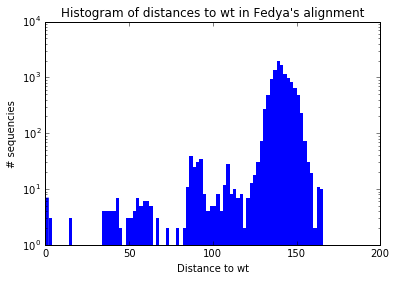

In [9]:
plt.hist(alignment['dist_to_wt'],bins=100,range=(0,200),edgecolor='none',log=True)
plt.ylabel('# sequencies')
plt.xlabel('Distance to wt')
plt.title('Histogram of distances to wt in Fedya\'s alignment')
plt.show()

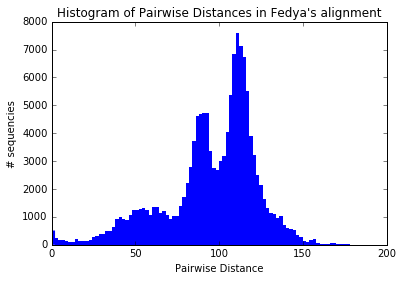

In [10]:
dists=[]
for i in range(length_of_alignment):
    for j in range(length_of_alignment):
        dists.append(hamdist(aa_seq_alignment[i],aa_seq_alignment[j]))
plt.hist(dists,bins=100,range=(0,200),edgecolor='none')
plt.ylabel('# sequencies')
plt.xlabel('Pairwise Distance')
plt.title('Histogram of Pairwise Distances in Fedya\'s alignment')
plt.show()

### Calculate shannon entropy ( '-' as 21 aa)

In [96]:
all_aa='ACDEFGHIKLMNPQRSTVWY'    #adding '-' as 21 change everything to much for S10
entropy=[]
for i_pos in range(length_of_alignment):
    ar=map(lambda x: x[i_pos],aa_seq_alignment)
    fr=[]
    for i_aa in all_aa:
        fr.append(ar.count(i_aa))
    fr=np.array(fr)*1./np.sum(fr)
    fr=[item for item in fr if item!=0]
    entropy_one=np.sum(map(lambda x: -x*np.log(x)/np.log(2),fr))
    entropy.append(entropy_one)
entropy=np.array(entropy)/(np.log(20.)/np.log(2))

all_aa='ACDEFGHIKLMNPQRSTVWY-'    #adding '-' as 21 change everything to much for S10
entropy_gap=[]
for i_pos in range(length_of_alignment):
    ar=map(lambda x: x[i_pos],aa_seq_alignment)
    fr=[]
    for i_aa in all_aa:
        fr.append(ar.count(i_aa))
    fr=np.array(fr)*1./np.sum(fr)
    fr=[item for item in fr if item!=0]
    entropy_one=np.sum(map(lambda x: -x*np.log(x)/np.log(2),fr))
    entropy_gap.append(entropy_one)
entropy_gap=np.array(entropy_gap)/(np.log(21.)/np.log(2))

In [100]:
all_aa='ACDEFGHIKLMNPQRSTVWY-'    #adding '-' as 21 change everything to much for S10
entropy_zhang=[]
for i_pos in range(length_of_alignment):
    ar=map(lambda x: x[i_pos],aa_seq_alignment)
    fr=[]
    for i_aa in all_aa:
        fr.append(ar.count(i_aa))
    fr0=np.array(fr)*1./np.sum(fr)
    fr=[item for item in fr0[:-1] if item!=0]
    entropy_one=np.sum(map(lambda x: -x*np.log(x)/np.log(20),fr))
    entropy_zhang.append(entropy_one+fr0[-1])


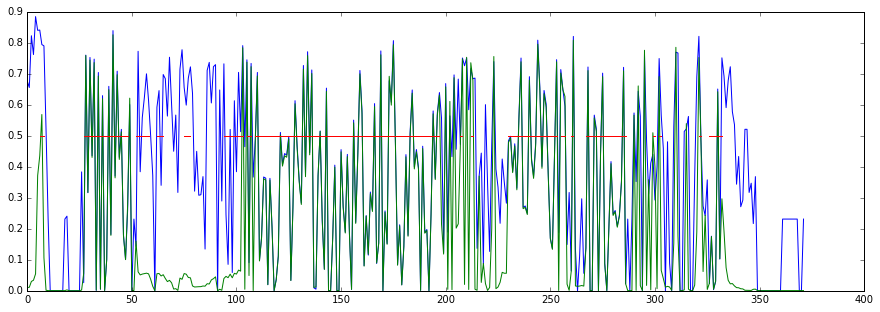

In [98]:
plt.figure(figsize=(15,5))
plt.plot(entropy)
plt.plot(entropy_gap)
plt.plot(np.where(np.array(map(lambda x: x,wt_aa_seq_alignment))=='-',np.nan*np.zeros(length_of_alignment),0.5*np.ones(length_of_alignment)),c='r')


### hash table from positions along Scer sequence to alignment positions

In [8]:
count=0
hash_positions=[]
for aa in wt_aa_seq_alignment:
    if (aa!='-'):
        hash_positions.append(count)
    count+=1

In [9]:
len(hash_positions),len(wt_aa_seq)

(220, 220)

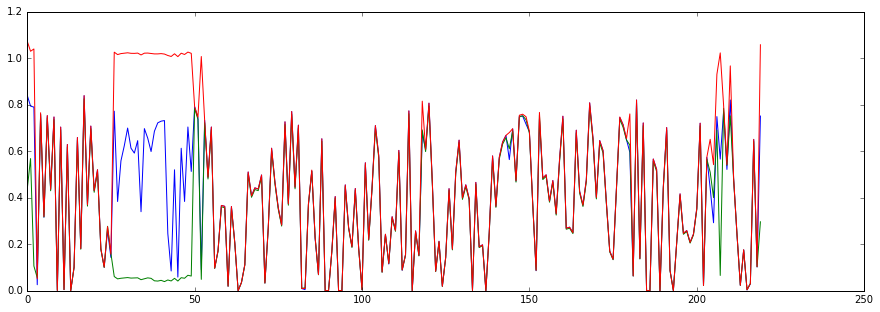

In [101]:
plt.figure(figsize=(15,5))
plt.plot(map(lambda i:entropy[i],hash_positions))
plt.plot(map(lambda i:entropy_gap[i],hash_positions))
plt.plot(map(lambda i:entropy_zhang[i],hash_positions))

# Valdar Score

### Calculate weights

In [10]:
aa_counts=[]
for i_pos in range(length_of_alignment):
    all_aa_in_position=map(lambda x: x[i_pos],aa_seq_alignment)
    tmp_dict={}
    for i_aa in list(set(all_aa_in_position)):
        tmp_dict[i_aa]=all_aa_in_position.count(i_aa)
    aa_counts.append(tmp_dict)

In [11]:
weights=[]
for i_seq in range(number_of_sequencies):
    tmp=0
    for i_pos in range(length_of_alignment):
        nx=aa_counts[i_pos][aa_seq_alignment[i_seq][i_pos]]
        kx=len(aa_counts[i_pos])
        tmp+=1./nx/kx
    weights.append(tmp/length_of_alignment)

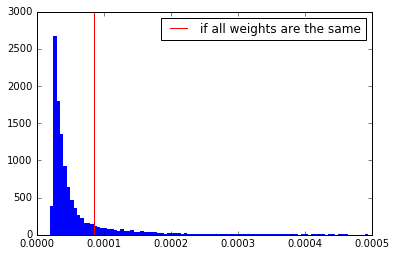

In [12]:
plt.hist(weights,bins=100,range=(0,0.0005),edgecolor='none')
plt.plot([1./number_of_sequencies,1./number_of_sequencies],[0,3000],c='r',label='if all weights are the same')
plt.legend()
plt.show()

Probably, I don't want to use weights because the weight would be big for sequence very unsimilar to all others. Which might be so distinct because it is an error of alignment. And we don't want to give it so much influence on our results

### Calculate shannon entropy

In [13]:
entropy_valder=[]
entropy_gap_valder=[]
for i_pos in range(length_of_alignment):
    p_aa=[]
    p_aa_gap=[]
    for i_aa in aa_counts[i_pos].keys():
        tmp=0
        for i_seq in range(number_of_sequencies):
            if (aa_seq_alignment[i_seq][i_pos]==i_aa):
                tmp+=weights[i_seq] #1./number_of_sequencies#
        p_aa_gap.append(tmp)
        if (i_aa!='-'):
            p_aa.append(tmp)
    entropy_gap_valder.append(np.sum(map(lambda x: -x*np.log(x)/np.log(2),p_aa_gap)))
    entropy_valder.append(np.sum(map(lambda x: -x/sum(p_aa)*np.log(x/sum(p_aa))/np.log(2),p_aa)))
entropy_gap_valder=np.array(entropy_gap_valder)/(np.log(21.)/np.log(2))
entropy_valder=np.array(entropy_valder)/(np.log(20.)/np.log(2))

In [12]:
plt.figure(figsize=(15,5))
plt.plot(map(lambda i:entropy[i],hash_positions),label='20 aa')
plt.plot(map(lambda i:entropy_gap[i],hash_positions),label='21 aa+\'-\'')
plt.plot(map(lambda i:entropy_valder[i],hash_positions),label='20 aa, weights')
plt.plot(map(lambda i:entropy_gap_valder[i],hash_positions),label='21 aa+\'-\', weights')
plt.legend()

NameError: global name 'entropy' is not defined

In [14]:
gap_valder=[]
for i_pos in range(length_of_alignment):
    tmp=0
    for i_seq in range(number_of_sequencies):
        if (aa_seq_alignment[i_seq][i_pos]=='-'):
            tmp+=weights[i_seq]#1./number_of_sequencies#
    gap_valder.append(tmp)

In [15]:
score_valder=(1-np.array(gap_valder))*(1-entropy_valder)

In [16]:
plt.figure(figsize=(15,5))
plt.plot(map(lambda i:1-entropy[i],hash_positions),label='20 aa')
plt.plot(map(lambda i:1-entropy_gap[i],hash_positions),label='21 aa+\'-\'')
plt.plot(map(lambda i:1-entropy_valder[i],hash_positions),label='21 aa+\'-\', weights')
plt.plot(map(lambda i:1-gap_valder[i],hash_positions),c='black',label='p_gap, weights')
plt.plot(map(lambda i:score_valder[i],hash_positions),label='score_valder')
plt.legend()
plt.ylim(0,1)

NameError: global name 'entropy' is not defined

(0, 55)

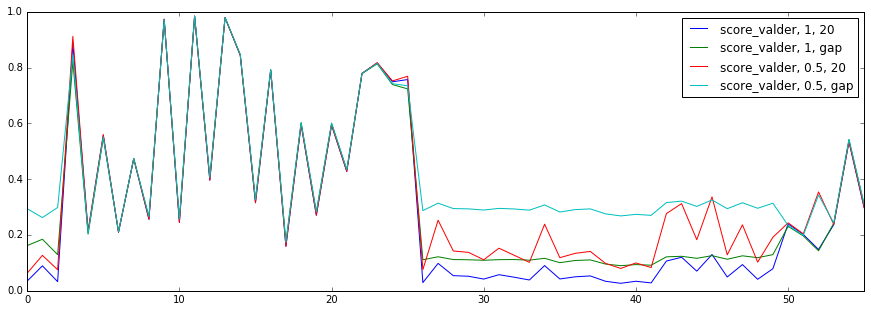

In [118]:
plt.figure(figsize=(15,5))

tmp_score_valder=(1-np.array(gap_valder))*(1-entropy_valder)
plt.plot(map(lambda i:tmp_score_valder[i],hash_positions),label='score_valder, 1, 20')

tmp_score_valder=(1-np.array(gap_valder))*(1-entropy_gap_valder)
plt.plot(map(lambda i:tmp_score_valder[i],hash_positions),label='score_valder, 1, gap')

tmp_score_valder=(1-np.array(gap_valder))**0.5*(1-entropy_valder)
plt.plot(map(lambda i:tmp_score_valder[i],hash_positions),label='score_valder, 0.5, 20')

tmp_score_valder=(1-np.array(gap_valder))**0.5*(1-entropy_gap_valder)
plt.plot(map(lambda i:tmp_score_valder[i],hash_positions),label='score_valder, 0.5, gap')

plt.legend()
plt.ylim(0,1)
plt.xlim(0,55)

(0, 1)

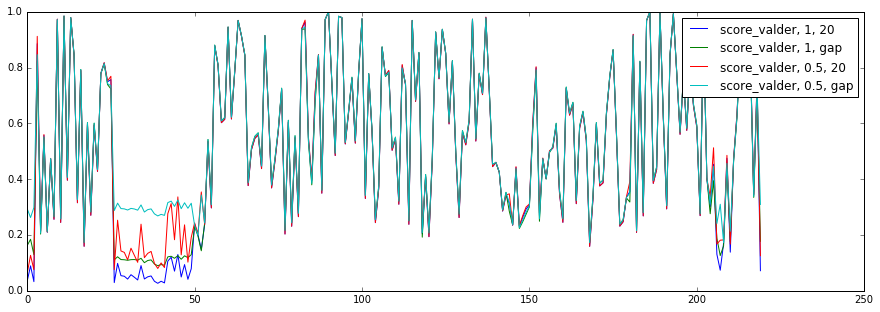

In [119]:
plt.figure(figsize=(15,5))

tmp_score_valder=(1-np.array(gap_valder))*(1-entropy_valder)
plt.plot(map(lambda i:tmp_score_valder[i],hash_positions),label='score_valder, 1, 20')

tmp_score_valder=(1-np.array(gap_valder))*(1-entropy_gap_valder)
plt.plot(map(lambda i:tmp_score_valder[i],hash_positions),label='score_valder, 1, gap')

tmp_score_valder=(1-np.array(gap_valder))**0.5*(1-entropy_valder)
plt.plot(map(lambda i:tmp_score_valder[i],hash_positions),label='score_valder, 0.5, 20')

tmp_score_valder=(1-np.array(gap_valder))**0.5*(1-entropy_gap_valder)
plt.plot(map(lambda i:tmp_score_valder[i],hash_positions),label='score_valder, 0.5, gap')

plt.legend()
plt.ylim(0,1)

In [26]:
conservation_score=pd.DataFrame()
conservation_score['entropy']=map(lambda i:entropy_valder[i],hash_positions)
conservation_score['gap_fr']=map(lambda i:gap_valder[i],hash_positions)
conservation_score['score']=(1-conservation_score['entropy'])*(1-conservation_score['gap_fr'])

In [29]:
for s in segm_set:
    start1=int(positions.loc['start_Scer','S'+str(s)])-1
    len1=int(positions.loc['len1','S'+str(s)])
    end1=start1+len1-1
    
    end2=int(positions.loc['end_Scer','S'+str(s)])-1
    len2=int(positions.loc['len2','S'+str(s)])
    start2=end2-len2+1
    #print start1,end1,len1,start2,end2,len2
    for i in range(start1,end1+1):
        conservation_score.set_value(i,'segment',s)
    for i in range(start2,end2+1):
        conservation_score.set_value(i,'segment',s)

In [30]:
conservation_score.to_csv(data_small+'/conservation_score.csv',sep='\t')

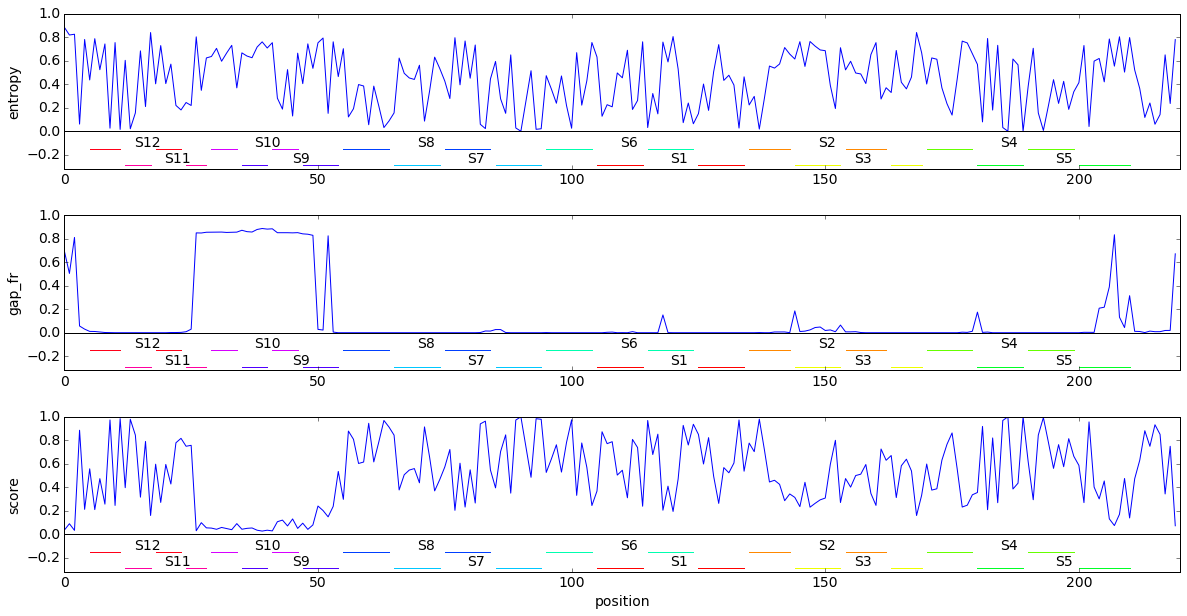

In [33]:
number = 12
cmap = plt.get_cmap('hsv')
colors = [cmap(i) for i in np.linspace(0, 1, number)]
fig=plt.figure(figsize=(20,10))
plt.rcParams.update({'font.size': 14,'legend.fontsize': 14})
plt.subplots_adjust(hspace = 0.3,wspace=0.3)
count=1
for name in ['entropy','gap_fr','score']:
    plt.subplot(3,1,count)
    plt.plot(conservation_score[name])
    plt.plot([0,220],[0,0],c='black')
    plt.xlim(0,220)
    for s in range(1,13,2):
        tmp=np.ones(len(conservation_score))*np.nan
        tmp_ind=conservation_score[conservation_score['segment']==s].index.values
        tmp[tmp_ind]=1
        plt.plot(-0.29*tmp,c=colors[s-1])
        plt.text(np.mean(tmp_ind), -0.27, 'S'+str(s))
    for s in range(2,13,2):
        tmp=np.ones(len(conservation_score))*np.nan
        tmp_ind=conservation_score[conservation_score['segment']==s].index.values
        tmp[tmp_ind]=1
        plt.plot(-0.15*tmp,c=colors[s-1])
        plt.text(np.mean(tmp_ind), -0.13, 'S'+str(s))
    count+=1
    plt.ylim(-0.32,1)
    plt.ylabel(name)
plt.xlabel('position')

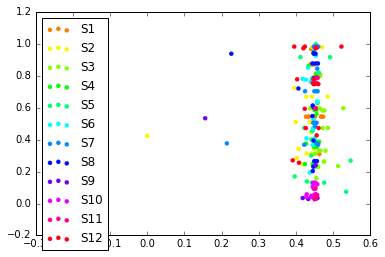

In [145]:
number = 13
cmap = plt.get_cmap('hsv')
colors = [cmap(i) for i in np.linspace(0, 1, number)]
for s in segm_set:
    mask=aa_all[s][(aa_all[s]['dist_Scer']==1)&(aa_all[s]['nat_lib']==1)]
    pos=map(lambda x: int(x[:-1]),mask['mut_list_Scer'])
    plt.scatter(mask['s'],conservation_score.iloc[pos]['score'],c=colors[s],edgecolor='none',label='S'+str(s))
    plt.legend(loc=2)
    plt.xlim(-0.3,0.6)

(0.25, 0.5)

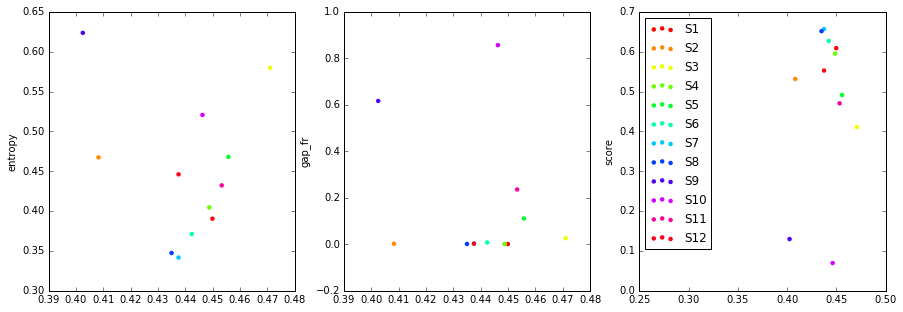

In [172]:
plt.figure(figsize=(15,5))
number = 12
cmap = plt.get_cmap('hsv')
colors = [cmap(i) for i in np.linspace(0, 1, number)]
for s in segm_set:
    mask=aa_all[s][(aa_all[s]['dist_Scer']==1)&(aa_all[s]['nat_lib']==1)]
    count=1
    for score in ['entropy','gap_fr','score']:
        plt.subplot(1,3,count)
        plt.scatter(np.mean(mask['s']),np.mean(conservation_score[conservation_score['segment']==s][score])\
                   ,c=colors[s-1],edgecolor='none',label='S'+str(s))
        count+=1
        plt.ylabel(score)
plt.legend(loc=2)
plt.xlim(0.25,0.5)

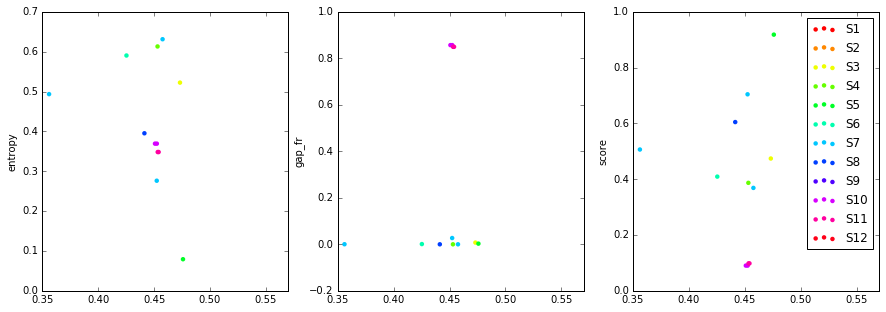

In [183]:
plt.figure(figsize=(15,5))
number = 12
cmap = plt.get_cmap('hsv')
colors = [cmap(i) for i in np.linspace(0, 1, number)]
for s in segm_set:
    mask=aa_all[s][(aa_all[s]['dist_Scer']==1)&(aa_all[s]['nat_lib']!=1)]
    mask=mask[(mask['mut_list'].map(lambda x: x.count(':'))==0)]
    pos=map(lambda x: int(x[:-1]),mask['mut_list_Scer'])
    count=1
    for score in ['entropy','gap_fr','score']:
        plt.subplot(1,3,count)
        plt.scatter(mask['s'],conservation_score.iloc[pos][score]\
                   ,c=colors[s-1],edgecolor='none',label='S'+str(s))
        count+=1
        plt.ylabel(score)
        plt.xlim(0.35,0.57)
plt.legend(loc=1)


In [180]:
mask

,aa_seq,t0_fr,t1_fr,t2_fr,t0_fr_var,t1_fr_var,t2_fr_var,size,y0,s,y0_std,s_std,nonsense,s_original,s_std_original,len,nogap,stop,shift,middle,mut_list,nat,lib,nat_lib,dist_Agos,dist_Anid,dist_Calb,dist_Cgla,dist_Cgui,dist_Clus,dist_Cpar,dist_Ctro,dist_Dhan,dist_Klac,dist_Kwal,dist_Lelo,dist_Ncra,dist_Sbay,dist_Scas,dist_Scer,dist_Sjap,dist_Sklu,dist_Soct,dist_Spom,dist_Ylip,dist_node_22,dist_node_23,dist_node_24,dist_node_25,dist_node_26,dist_node_27,dist_node_28,dist_node_29,dist_node_30,dist_node_31,dist_node_32,dist_node_33,dist_node_34,dist_node_35,dist_node_36,dist_node_37,dist_node_38,dist_node_39,dist_node_40,dist_node_41,dist_min_sp,dist_min_all,mut_list_Scer
29876,EALGAVKGVKRFGSGFVPLDEALSRAVVDL,1.556562,1.838464,2.486509,0.039756,0.061095,0.222149,1,1.500234,0.439081,0.072905,0.008135,0,0.24901,0.023097,30,1,0,0,0,6K:16V,0,0,0,3,8,3,4,3,2,3,2,2,2,2,3,6,1,3,1,6,2,5,6,5,3,3,3,3,2,2,2,1,1,1,1,2,2,1,2,2,2,2,5,6,1,1,112K:122V
